# Analysing SBN: SG with scaled BN over image and language models

In this notebook we use BN (Batch Normalization) over both the image and language models. However, this time we scale the BN layers outputs in order to control the models statistics and their update rates. We'll see that by scaling the BN outputs we reulerize the model and improve the model's performances. The models outputs can be found in <font color='red'>./logs/SBN</font> (note that the update rates in the logs are scaled by 100)

In [1]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
sys.path.append('../models/')
import retriever
from stats import stats
from tabulate import tabulate
from runSBN import RunModel as Model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
trainset_file = '../data/training/train_data.bin'
testset_file = '../data/training/test_data.bin'
vocab_file =  '../data/metadata/w2v_vocab.json'
params_dir_tmp = '../data/training/models/SBN/'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n-1 items where each item is [bounding box vector, bounding box spatial features]. Note that different entries  might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the true bbox </li>
</ul>

In [3]:
trainset = np.load(open(trainset_file, 'rb'))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])

testset = np.load(open(testset_file, 'rb'))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

Number of words: 8242


## SBN

<p>
For this exaperiment we've got the best performances by scaling the image features by 0.0095374 and the language features by 0.07609548. Its clear that by scaling the BN layers outputs, the training behavior became more stable. This yiels a better model both in terms of P@1 and regularization. 
</p>

In [1]:
params_dir = params_dir_tmp+'SBN'
tf.reset_default_graph()
m = Model(
    batch_size=200, 
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    bbox_dims=testset[0][1][1].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    bnorm=True,
    Urnn_norm=True, 
    Uatt_norm=True, 
    Qscale=0.07609548,
    IMGscale=0.0095374,
    params_dir=params_dir)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn, imgMean_list, imgSTD_list, imgRange_list, qMean_list, qSTD_list, qRange_list, Gq, Gimg = m.train(
    trainset, testset, epochs_num=100)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.915
Test accuracy:0.749
Train IOU:0.953
Test IOU:0.831
Train loss loss:0.497
Test loss loss:1.218


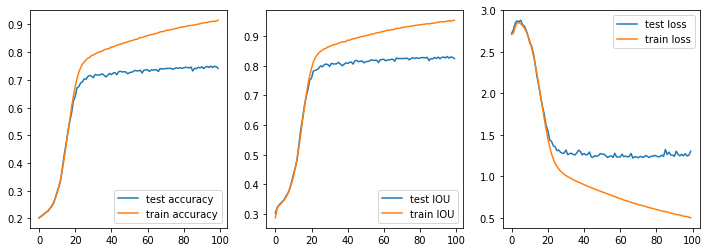

---------------------------------------------------------------------------------------------------- 



In [133]:
f = stats([tst1], [trn1], epochs=100, params=[200])

<p>Looking at the graphs below we see that the language features ranges is higher than the image one. This is a good practice: the image embedding is an order of magnitude higher than the language embedding and that might make the image update rate too small (compared to the language update rate), hence, by increasing the language range, compared to the image one, we can balance the too models update rates.</p>

<p>However, we saw at notebook <font color='red'>CDS_Analysis</font>, that using a regular BN layer over the language model also yields a higher features range for the language model. Nevertheless, without scaling, the difference between the models features ranges was too small and hence the different between the models update rates was also too small. This made it easier for the image model to overfit the small and slow changing language embeddings.</p>

<p>Indeed, we can see that the ratio between the models update rates are much more stable. Note that the update rates are somewhat similar to the those we've got when we've added a BN layer only over the image model which implies a more curvier error suffice.</p>

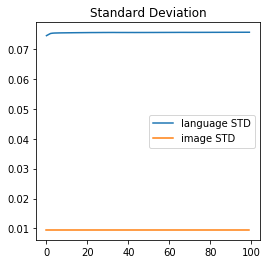

In [134]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qSTD1_list, imgSTD1_list]
labels=[['language STD'], ['image STD']]
titles=["Standard Deviation"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr)
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

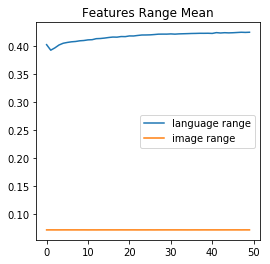

In [135]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [qRange1_list, imgRange1_list]
labels=[['language range'], ['image range']]
titles=["Features Range Mean"]
epochs=50

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:50])
    P.legend([labels[k][0] for k in range(len(labels))], loc=0)
    P.set_title(title)
    P.plot()
plt.show()

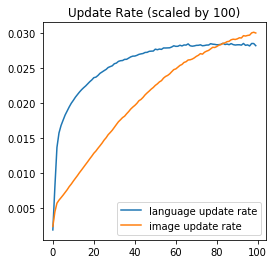

In [137]:
f, P = plt.subplots(1, 1, figsize=(4,4))
data = [Gq1, Gimg1]
labels=[['language update rate'], ['image update rate']]
titles=["Update Rate (scaled by 100)"]
epochs=100

for i in range(len(data)):
        if type(data[i])!=np.ndarray:
            data[i] = np.array(data[i])
            
for j, title in enumerate(titles):
    for arr in data:
        P.plot(range(epochs), arr[:100])
    P.legend([labels[k][0] for k in range(len(labels))])
    P.set_title(title)
    P.plot()
plt.show()